# Homework - Week 3
author: Caio Geraldes

## Loading data and packages

In [2]:
library(tidyverse)
library(rethinking)
library(ggdag)
library(dagitty)

In [3]:
data(foxes)
df <- tibble(foxes)
head(df)

group,avgfood,groupsize,area,weight
<int>,<dbl>,<int>,<dbl>,<dbl>
1,0.37,2,1.09,5.02
1,0.37,2,1.09,2.84
2,0.53,2,2.05,5.33
2,0.53,2,2.05,6.07
3,0.49,2,2.12,5.85
3,0.49,2,2.12,3.25


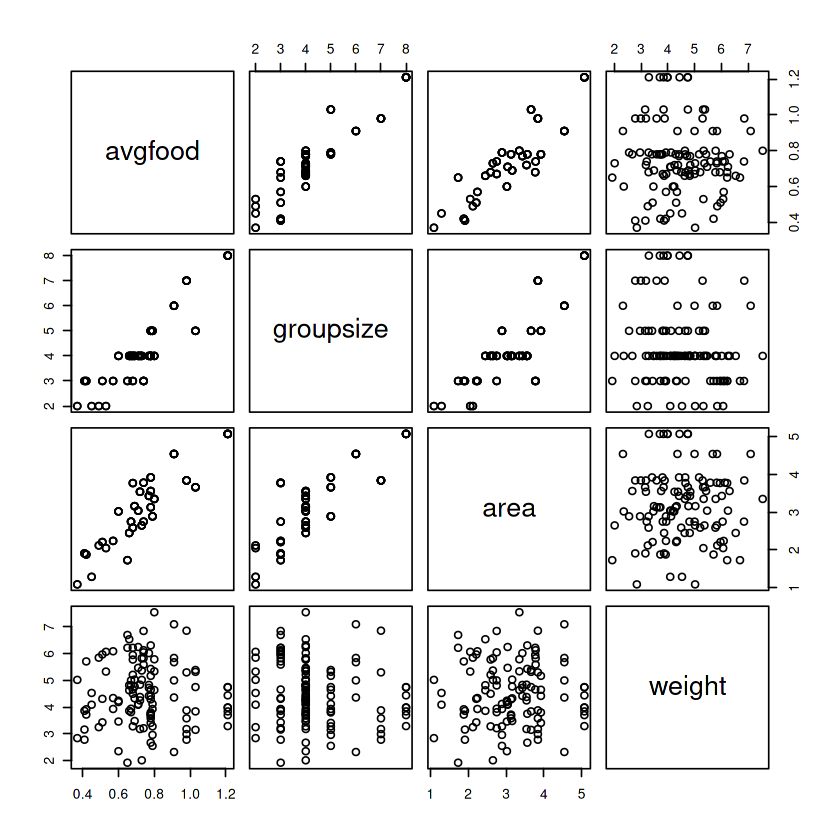

In [4]:
df %>% select(c('avgfood', 'groupsize', 'area', 'weight')) %>% plot()

## Exercice 1

### Question

The first two problems arebased on the same data. The data in data(foxes) are 116 foxes from 30 different urban groups in England. These fox groups are like street gangs. Group size (groupsize) varies from 2 to 8 individuals.
Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information.
Some territories also have more avgfood than others. And food influences
the weight of each fox. Assume this DAG:

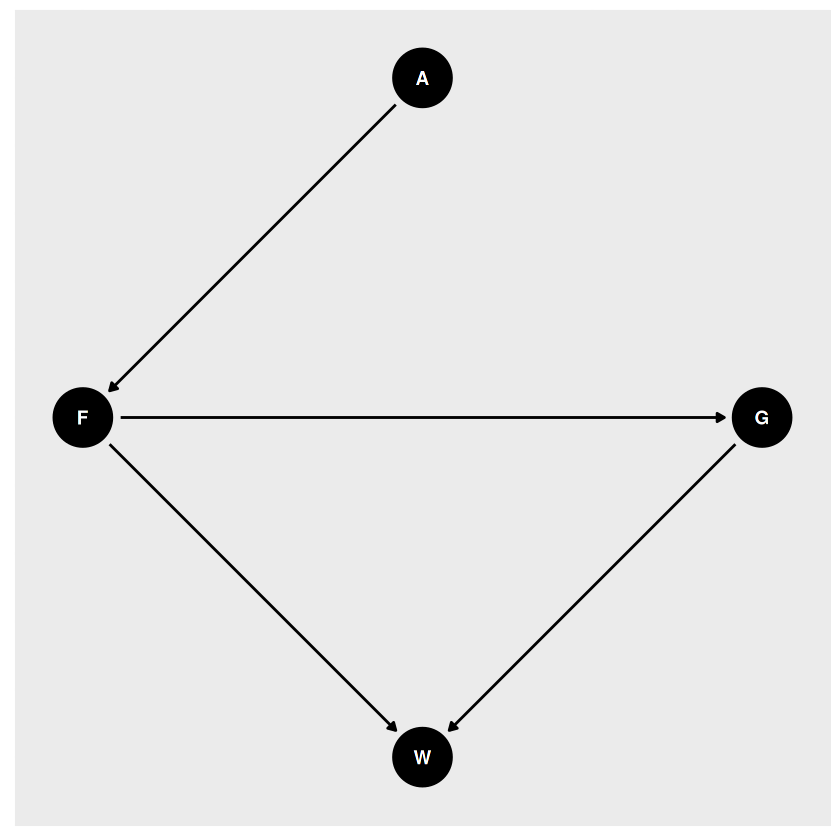

In [5]:
dag <- dagitty('dag{
A [exposure,pos="3.5,5.05"]
F [outcome,pos="3,5"]
G [pos="4,5"]
W [pos="3.5,4.95"]
A -> F
F -> G
F -> W
G -> W
}')
ggdag(dag) + theme_dag_gray()

where F is avgfood, G is groupsize, A is area, and W is weight.
Use the backdoor criterion and estimate the total causal influence of A on F. What effect would increasing the area of a territory have on the amount of food inside it?

### Answer:

There are no backdoors to A(rea), so the total causal influence of A on F is given by $f(A) = F$.

In [6]:
dagitty::adjustmentSets(dag, effect = 'total')

 {}

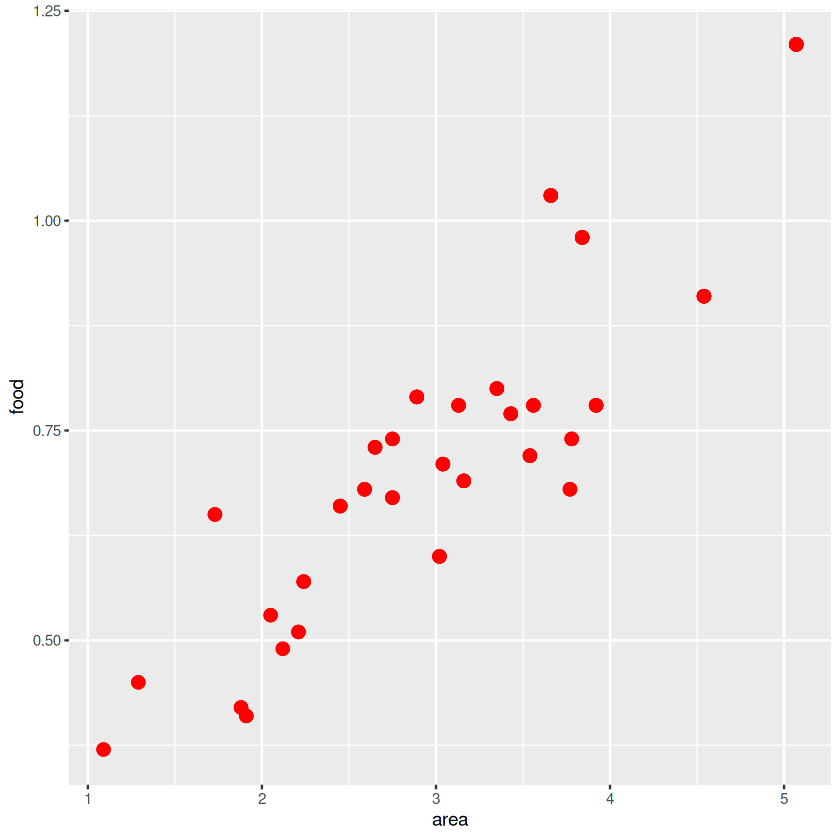

In [7]:
df %>% ggplot(aes(x=area, y=avgfood)) +
    geom_point(size=3, color="red") +
    xlab('area') +
    ylab('food')

#### Standardizing variables

In [8]:
df$std.area <- standardize(df$area)
df$std.food <- standardize(df$avgfood)
dat <- tibble(area=df$std.area, food=df$std.food)

#### Modeling

$food \sim \text{Normal}(\mu, \sigma)$

$\mu = \alpha + \beta*area$

$\alpha \sim \text{Normal}(0,0.2)$

$\beta \sim \text{Normal}(0,0.5)$

$\sigma \sim \text{Exponential}(1)$

In [9]:
model.1 <- quap(
    alist(
        food ~ dnorm(mu, sigma),
        mu <- alpha + beta * area,
        alpha ~ dnorm(0,0.2),
        beta ~ dnorm(0,0.5),
        sigma ~ dexp(1)
        ),
    data=dat)
model.1


Quadratic approximate posterior distribution

Formula:
food ~ dnorm(mu, sigma)
mu <- alpha + beta * area
alpha ~ dnorm(0, 0.2)
beta ~ dnorm(0, 0.5)
sigma ~ dexp(1)

Posterior means:
       alpha         beta        sigma 
6.258124e-08 8.764784e-01 4.662583e-01 

Log-likelihood: -76.32 

##### Prior distribution

In [10]:
priors <- extract.prior(model.1)
prior <- tibble(alpha=priors$alpha, beta=priors$beta)

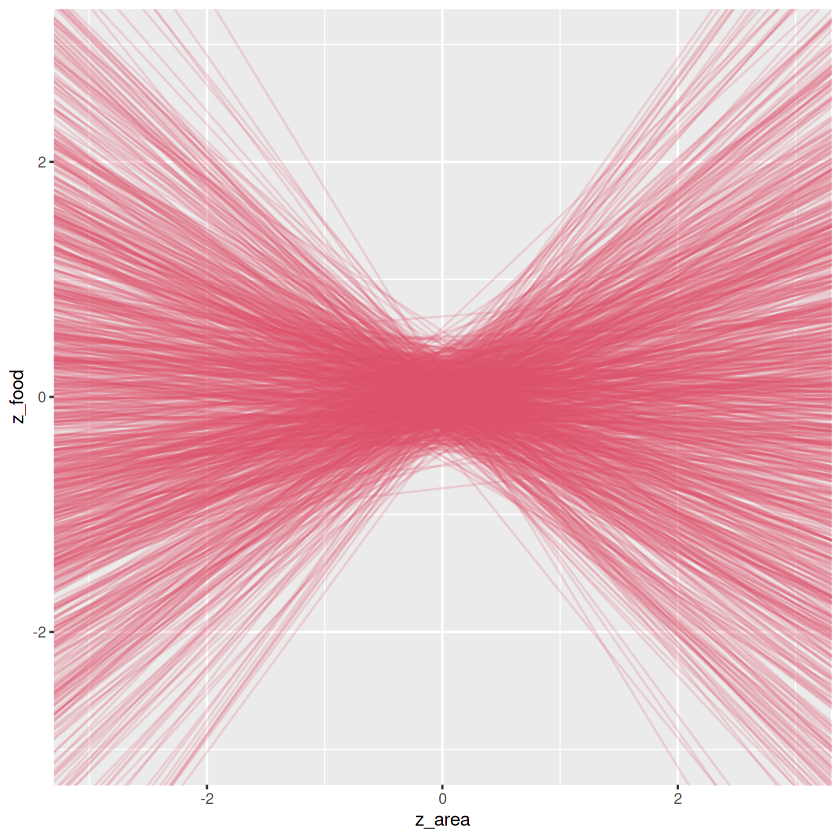

In [11]:
ggplot() +
    scale_x_continuous(limits = c(-3,3)) +
    scale_y_continuous(limits = c(-3,3)) +
    geom_abline(data = prior,
                mapping = aes(slope=beta, intercept=alpha),
                alpha=0.2, color=2) +
    xlab('z_area') +
    ylab('z_food')

#### Sampling from the posterior

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
alpha,-0.0007079244,0.04217742,-0.06851156,0.06618287,▁▁▂▇▇▂▁▁
beta,0.8764293266,0.04325275,0.80679771,0.94581128,▁▁▁▃▇▃▁▁
sigma,0.4662441228,0.03039232,0.41801323,0.51507102,▁▁▁▁▁▃▇▇▅▂▁▁▁▁


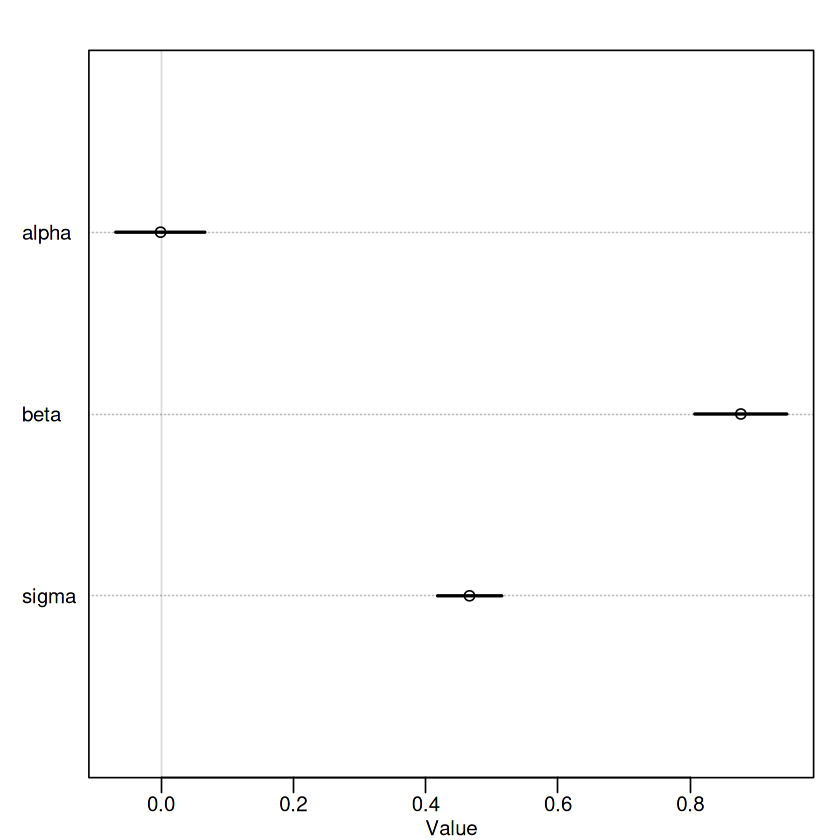

In [12]:
post.1 <- extract.samples(model.1)
precis(post.1)
plot(precis(post.1))

In [13]:
xseq <- seq(from=-3, to=3, length.out = 1e4)
f_sim <- sim(model.1,data=list(area=xseq))
f_sim.min <- apply(f_sim,2,PI)['5%',]
f_sim.max <- apply(f_sim,2,PI)['94%',]
f.sim <- tibble(x=xseq, min=f_sim.min, max=f_sim.max)

mu <- link(model.1,
             data=list(area=xseq))
mu.mean <- apply(mu,2,mean)
mu.min <- apply(mu,2,PI,prob=0.99)["1%",]
mu.max <- apply(mu,2,PI,prob=0.99)["100%",]

mu.df <- tibble(x=xseq, min=mu.min, max=mu.max)

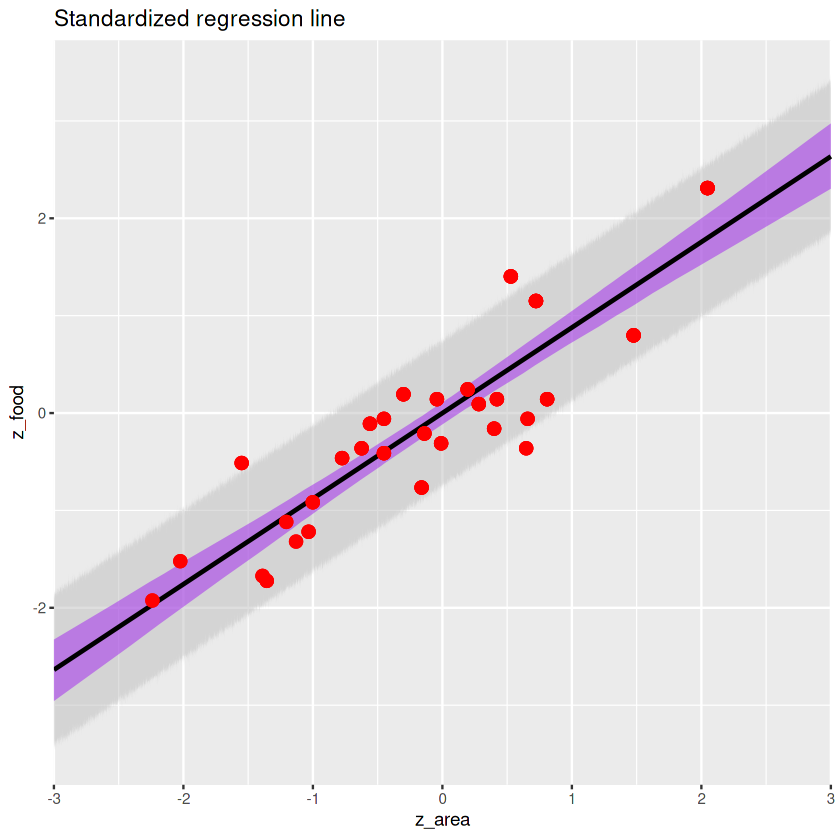

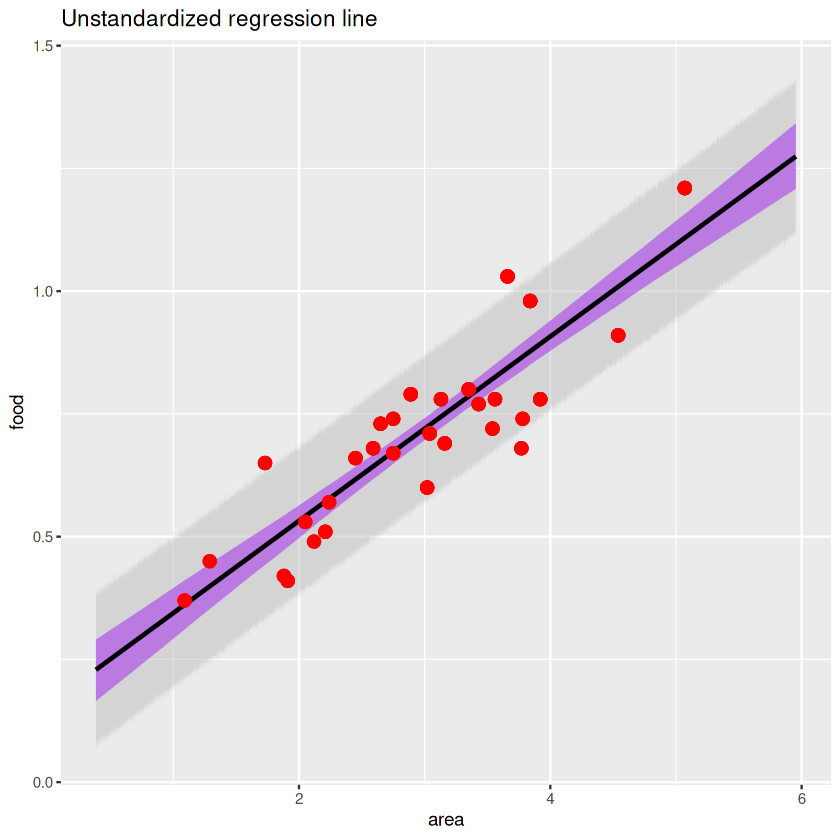

In [14]:
ggplot() +
    scale_x_continuous(limits=c(-3,3), expand = c(0,0)) +
    geom_ribbon(mapping = aes(x=x, ymax=max, ymin=min),
             fill='grey', alpha=0.5, data=f.sim) +
    geom_ribbon(aes(x=xseq, ymax=max, ymin=min),
              data=mu.df, fill='purple', alpha=0.5) +
    geom_line(aes(x=xseq, y=mu.mean), size=1, color='black') +
    geom_point(aes(x=std.area, y=std.food), data=df, color="red", size=3) +
    xlab('z_area') +
    ylab('z_food') +
    labs(title='Standardized regression line')

unstd.pred = tibble(
    food.mean = mean(df$avgfood) + (mu.mean*sd(df$avgfood)),
    food.max = mean(df$avgfood) + (mu.max*sd(df$avgfood)),
    food.min = mean(df$avgfood) + (mu.min*sd(df$avgfood)),
    food.sim.min = mean(df$avgfood) + (f_sim.min*sd(df$avgfood)),
    food.sim.max = mean(df$avgfood) + (f_sim.max*sd(df$avgfood)),
    area=mean(df$area) + (xseq*sd(df$area)))  

ggplot(unstd.pred) +
    geom_ribbon(aes(x=area, ymax=food.sim.max, ymin=food.sim.min), fill='gray', alpha=0.5) + 
    geom_ribbon(aes(x=area, ymax=food.max, ymin=food.min), fill='purple', alpha=0.5) + 
    geom_line(aes(x=area, y=food.mean), size=1) + 
    geom_point(aes(x=area, y=avgfood), data=df, color='red', size=3) +
    xlab('area') +
    ylab('food') +
    labs(title = 'Unstandardized regression line')

#### Interpretation

For each increase of one standard deviation in the area, there is an increase of around 0.81 to 0.94 standard deviations in the avarage food available for the foxes.

5%       94% 
0.8067977 0.9458113

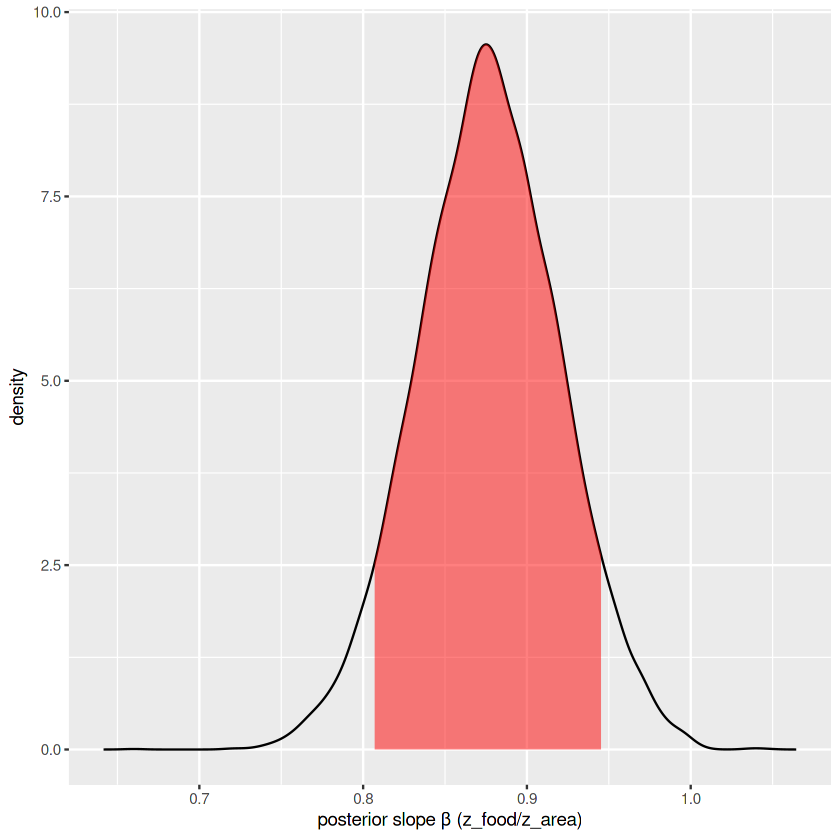

In [15]:
post.1.b <- post.1$b
(pi89.post.1.b <- PI(post.1.b))

b_dens <- with(density(post.1.b), tibble(x, y))
b_dens %>% ggplot(aes(x,y)) +
    geom_line() +
    geom_area(data=subset(b_dens, x > pi89.post.1.b[1] & x < pi89.post.1.b[2]), fill = "red", alpha=0.5) +
    xlab("posterior slope β (z_food/z_area)") +
    ylab('density')

## Exercice 2

### Question
Now infer both the total and direct causal effects of adding food F to a territory on the weight W of foxes. Which covariates do you need to adjust for in each case? In light of your estimates from this problem and the previous
one, what do you think is going on with these foxes? Feel free to speculate — all that matters is that you justify your speculation.

## Answer

### Total effect of adding food to a territory on the weight of foxes

For attaining the total effect of adding food on the weight of foxes, it is not necessary to extratify the causal relations, as part of the effect flows through `G`, the group of observed foxes, and `A` is an antecedent of `F`. There are no open backdoors.

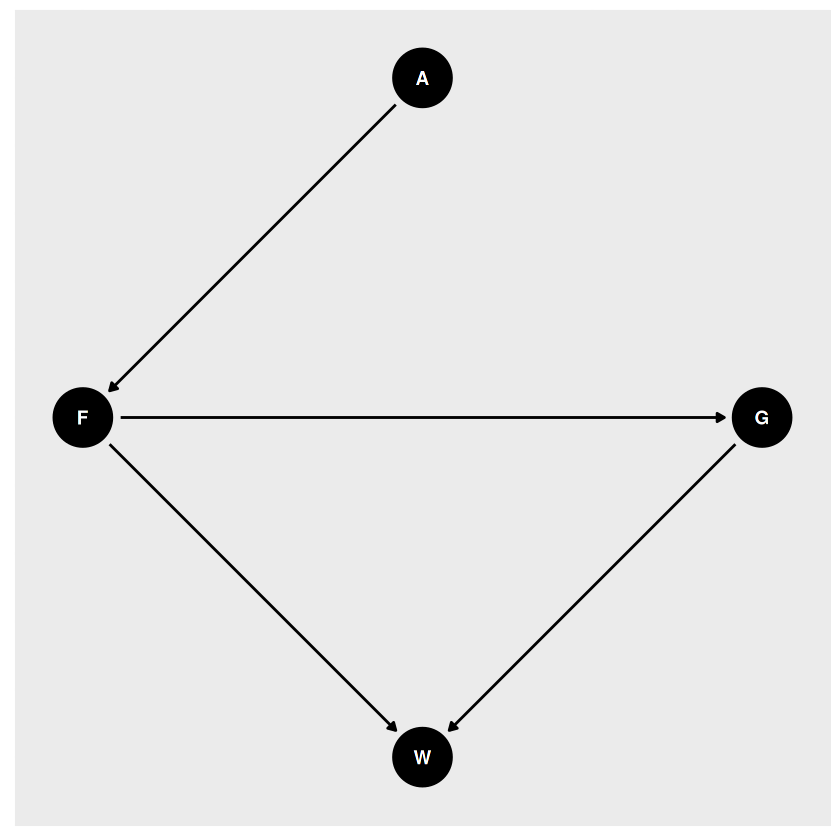

In [16]:
dag <- dagitty('dag{
A [pos="3.5,5.05"]
F [exposure,pos="3,5"]
G [pos="4,5"]
W [outcome,pos="3.5,4.95"]
A -> F
F -> G
F -> W
G -> W
}')
ggdag(dag) + theme_dag_gray()

In [17]:
dagitty::adjustmentSets(dag, effect = 'total')

 {}

In [18]:
df$std.weight <- standardize(df$weight)
df$std.food <- standardize(df$avgfood)
dat <- tibble(weight=df$std.weight, food=df$std.food)

#### Modeling

$w \sim \text{Normal}(\mu, \sigma)$

$\mu = \alpha + \beta*food$

$\alpha \sim \text{Normal}(0,0.2)$

$\beta \sim \text{Normal}(0,0.5)$

$\sigma \sim \text{Exponential}(1)$

In [19]:
model.2 <- quap(
    alist(
        weight ~ dnorm(mu, sigma),
        mu <- alpha + beta * food,
        alpha ~ dnorm(0,0.2),
        beta ~ dnorm(0,0.5),
        sigma ~ dexp(1)
        ),
    data=dat)
model.2


Quadratic approximate posterior distribution

Formula:
weight ~ dnorm(mu, sigma)
mu <- alpha + beta * food
alpha ~ dnorm(0, 0.2)
beta ~ dnorm(0, 0.5)
sigma ~ dexp(1)

Posterior means:
        alpha          beta         sigma 
-2.263104e-07 -2.421004e-02  9.911435e-01 

Log-likelihood: -164.06 

##### Prior distribution

In [20]:
priors <- extract.prior(model.2)
prior <- tibble(alpha=priors$alpha, beta=priors$beta)

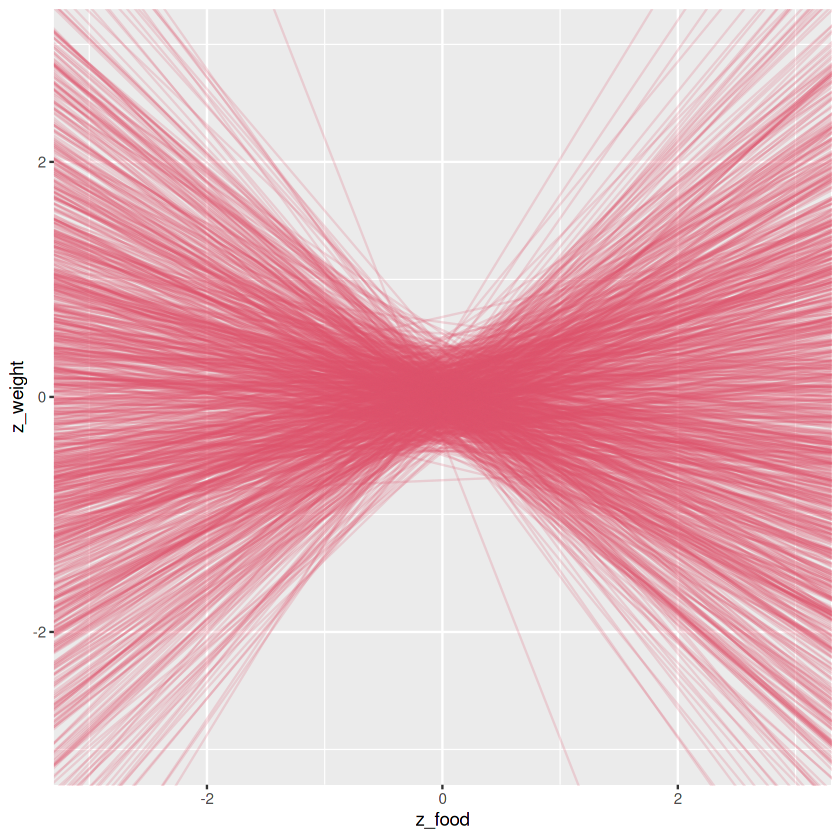

In [21]:
ggplot() +
    scale_x_continuous(limits = c(-3,3)) +
    scale_y_continuous(limits = c(-3,3)) +
    geom_abline(data = prior,
                mapping = aes(slope=beta, intercept=alpha),
                alpha=0.2, color=2) +
    xlab('z_food') +
    ylab('z_weight')

#### Sampling from the posterior

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
alpha,0.0002183501,0.08340782,-0.1322324,0.1348063,▁▁▁▁▂▅▇▇▅▂▁▁▁▁
beta,-0.0236041616,0.08978293,-0.1658286,0.1197860,▁▁▁▂▃▇▇▇▃▂▁▁▁▁
sigma,0.9913566615,0.06435713,0.8889569,1.0937604,▁▁▂▅▇▇▃▁▁▁


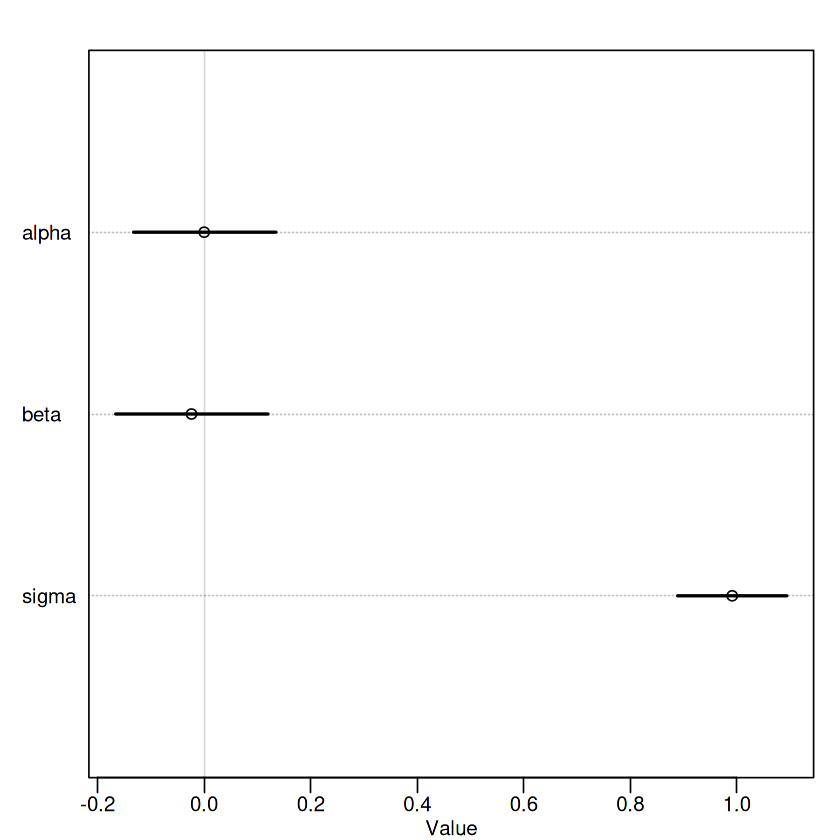

In [22]:
post.2 <- extract.samples(model.2)
precis(post.2)
plot(precis(post.2))

5%        94% 
-0.1658286  0.1197860

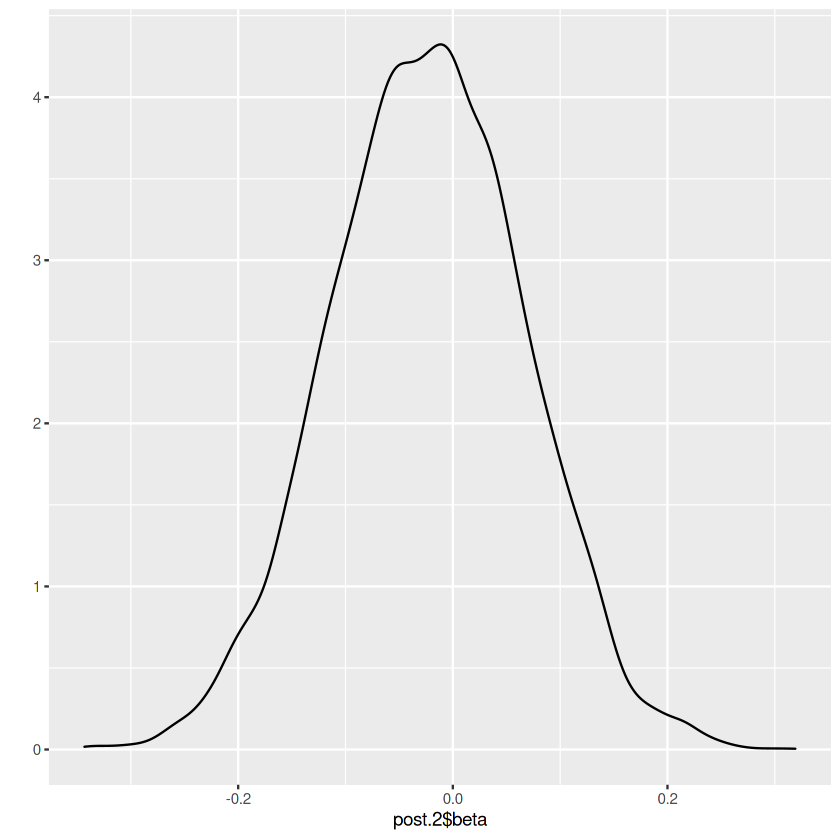

In [23]:
PI(post.2$beta)
qplot(post.2$beta, geom='density')

In [24]:
xseq <- seq(from=-3, to=3, length.out = 1e4)
w_sim <- sim(model.2,data=list(food=xseq))
w_sim.min <- apply(w_sim,2,PI)['5%',]
w_sim.max <- apply(w_sim,2,PI)['94%',]
w.sim <- tibble(x=xseq, min=w_sim.min, max=w_sim.max)

mu <- link(model.2,
             data=list(food=xseq))
mu.mean <- apply(mu,2,mean)
mu.min <- apply(mu,2,PI,prob=0.89)["5%",]
mu.max <- apply(mu,2,PI,prob=0.89)["94%",]

mu.df <- tibble(x=xseq, min=mu.min, max=mu.max)

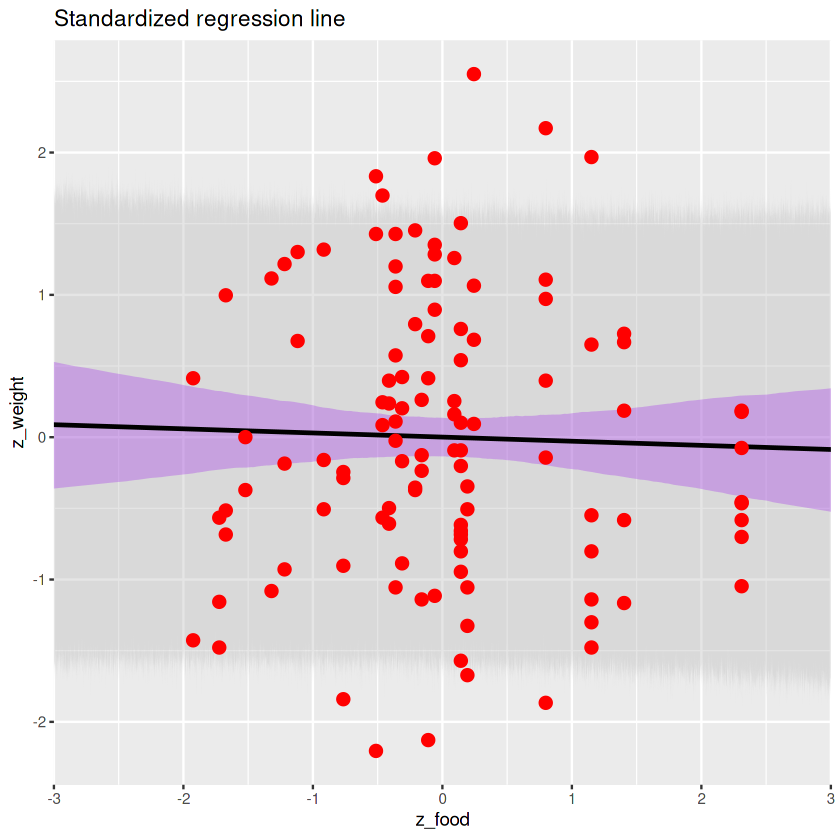

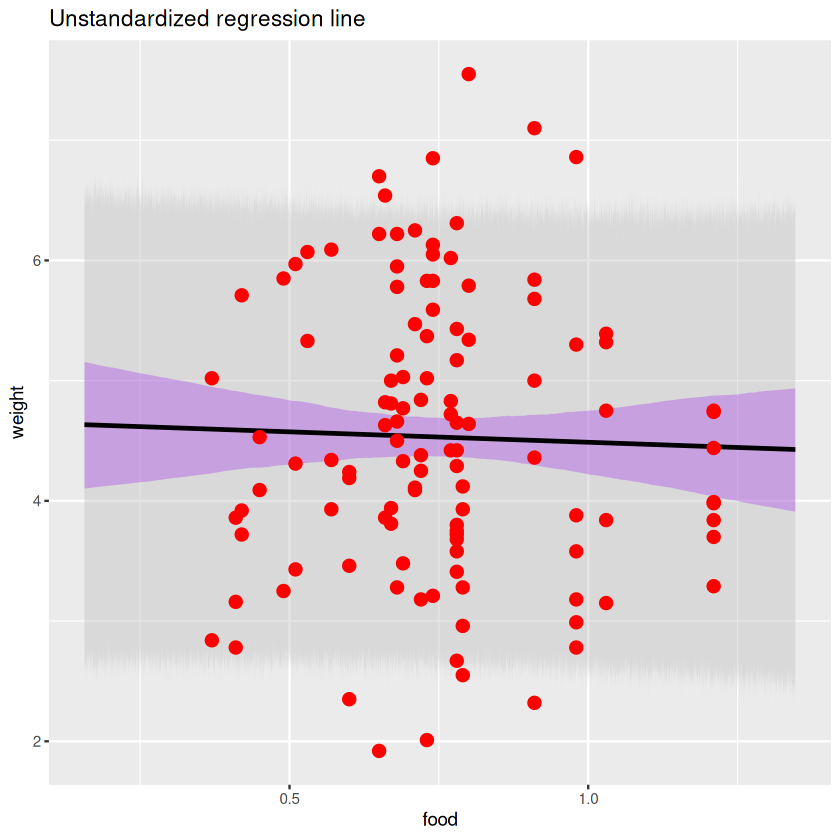

In [25]:
ggplot() +
    scale_x_continuous(limits=c(-3,3), expand = c(0,0)) +
    geom_ribbon(mapping = aes(x=x, ymax=max, ymin=min),
             fill='grey', alpha=0.4, data=w.sim) +
    geom_ribbon(aes(x=xseq, ymax=max, ymin=min),
              data=mu.df, fill='purple', alpha=0.3) +
    geom_line(aes(x=xseq, y=mu.mean), size=1, color='black') +
    geom_point(aes(x=std.food, y=std.weight), data=df, color="red", size=3) +
    xlab('z_food') +
    ylab('z_weight') +
    labs(title='Standardized regression line')

unstd.pred = tibble(
    weight.mean = mean(df$weight) + (mu.mean*sd(df$weight)),
    weight.max = mean(df$weight) + (mu.max*sd(df$weight)),
    weight.min = mean(df$weight) + (mu.min*sd(df$weight)),
    weight.sim.min = mean(df$weight) + (w_sim.min*sd(df$weight)),
    weight.sim.max = mean(df$weight) + (w_sim.max*sd(df$weight)),
    food=mean(df$avgfood) + (xseq*sd(df$avgfood)))  

ggplot(unstd.pred) +
    geom_ribbon(aes(x=food, ymax=weight.sim.max, ymin=weight.sim.min), fill='gray', alpha=0.4) +
    geom_ribbon(aes(x=food, ymax=weight.max, ymin=weight.min), fill='purple', alpha=0.3) +
    geom_line(aes(x=food, y=weight.mean), size=1) + 
    geom_point(aes(x=avgfood, y=weight), data=df, color='red', size=3) +
    xlab('food') +
    ylab('weight') +
    labs(title = 'Unstandardized regression line')

#### Interpretation

For each increase of one standard deviation in the food, there is an increase of around -0.17 to 0.12 standard deviations in the weight of the foxes. This effect is very small, overall.

5%        94% 
-0.1658286  0.1197860

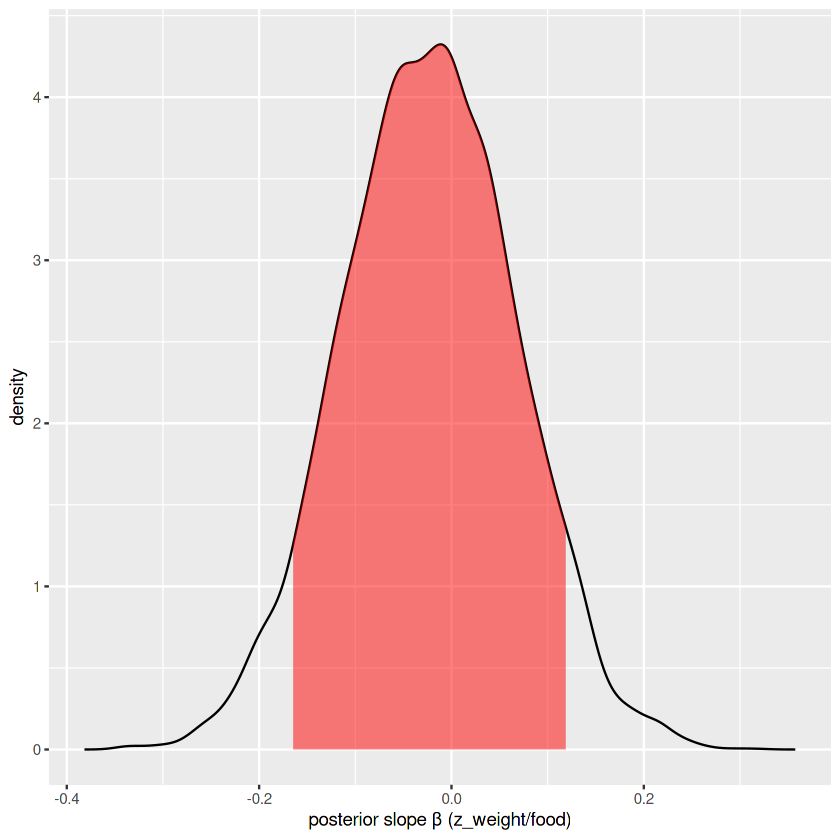

In [26]:
post.2.b <- post.2$b
(pi89.post.b.2 <- PI(post.2.b))

b_dens <- with(density(post.2.b), tibble(x, y))
b_dens %>% ggplot(aes(x,y)) +
    geom_line() +
    geom_area(data=subset(b_dens, x > pi89.post.b.2[1] & x < pi89.post.b.2[2]), fill = "red", alpha=0.5) +
    xlab("posterior slope β (z_weight/food)") +
    ylab('density')

### Direct effect of adding food to a territory on the weight of foxes

As `G`(group size) is a confunder, more specifically a pipe between `F` and `W`, it should be stratified.

In [27]:
dagitty::adjustmentSets(dag, effect = 'direct')

{ G }

In [28]:
df$std.groupsize <- standardize(df$groupsize)

dat <- tibble(food = df$std.food, weight = df$std.weight, groupsize = df$std.groupsize)

#### Modeling

$w \sim \text{Normal}(\mu, \sigma)$

$\mu = \alpha + \beta_f*food + \beta_g * group\ size$

$\alpha \sim \text{Normal}(0,0.2)$

$\beta_f \sim \text{Normal}(0,0.5)$

$\beta_g \sim \text{Normal}(0,0.5)$

$\sigma \sim \text{Exponential}(1)$

In [29]:
model.2b <- quap(
    alist(
        weight ~ dnorm(mu, sigma),
        mu <- alpha + beta_f * food + beta_g * groupsize,
        alpha ~ dnorm(0,0.2),
        beta_f ~ dnorm(0,.5),
        beta_g ~ dnorm(0,.5),
        sigma ~ dexp(1)
        ),
    data=dat)
model.2b


Quadratic approximate posterior distribution

Formula:
weight ~ dnorm(mu, sigma)
mu <- alpha + beta_f * food + beta_g * groupsize
alpha ~ dnorm(0, 0.2)
beta_f ~ dnorm(0, 0.5)
beta_g ~ dnorm(0, 0.5)
sigma ~ dexp(1)

Posterior means:
        alpha        beta_f        beta_g         sigma 
 7.350297e-08  4.772533e-01 -5.735262e-01  9.420433e-01 

Log-likelihood: -158.14 

In [30]:
post.2b <- extract.samples(model.2b)

In [31]:
PI(post.2b$beta_g)

5%        94% 
-0.8605018 -0.2880869

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
alpha,-0.0002171249,0.08013749,-0.1277312,0.1294875,▁▁▁▂▅▇▇▅▂▁▁▁▁
beta_f,0.4786007491,0.17882198,0.1896853,0.7624522,▁▁▁▁▃▅▇▇▅▂▁▁▁▁
beta_g,-0.5762685820,0.17889861,-0.8605018,-0.2880869,▁▁▂▇▇▂▁▁
sigma,0.9430096929,0.06185668,0.8440368,1.0416596,▁▁▁▃▇▇▃▁▁▁


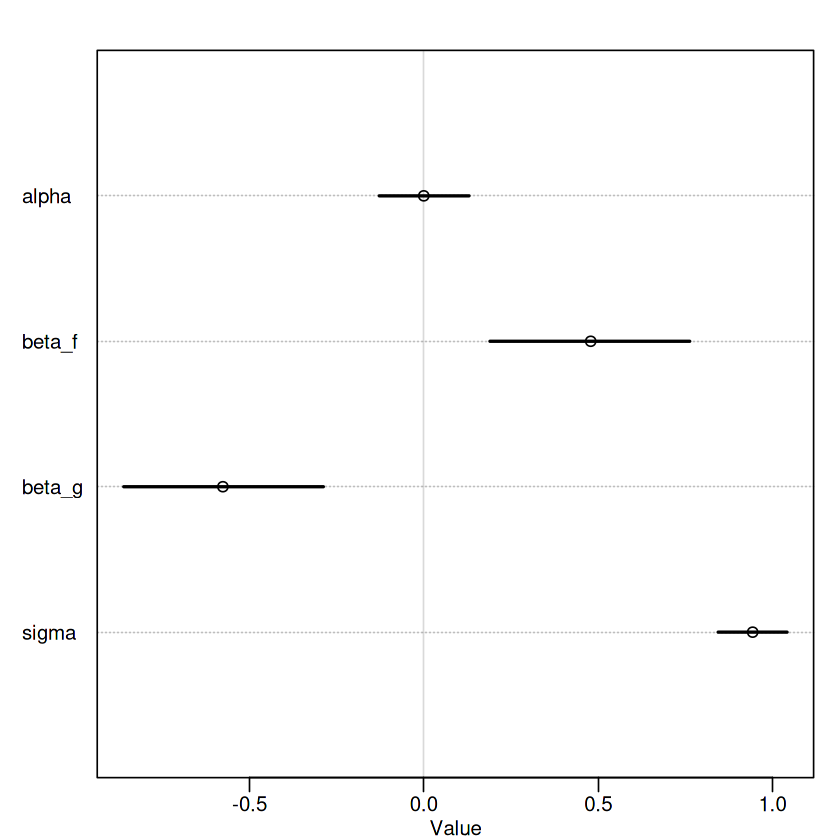

In [32]:
precis(post.2b)
plot(precis(post.2b))

In [33]:
vcov(model.2b)
cov2cor(vcov(model.2b))

,alpha,beta_f,beta_g,sigma
alpha,6.422103e-03,-1.322213e-10,1.338534e-10,4.999327e-10
beta_f,-1.322213e-10,3.208510e-02,-2.809485e-02,-1.008552e-03
beta_g,1.338534e-10,-2.809485e-02,3.209172e-02,1.021001e-03
sigma,4.999327e-10,-1.008552e-03,1.021001e-03,3.813366e-03


,alpha,beta_f,beta_g,sigma
alpha,1.000000e+00,-9.211091e-09,9.323826e-09,1.010226e-07
beta_f,-9.211091e-09,1.000000e+00,-8.755451e-01,-9.117848e-02
beta_g,9.323826e-09,-8.755451e-01,1.000000e+00,9.229442e-02
sigma,1.010226e-07,-9.117848e-02,9.229442e-02,1.000000e+00


In [34]:
mu <- link(model.2b)

mu_mean <- apply( mu , 2 , mean )
mu.min <- apply(mu,2,PI,prob=0.89)["5%",]
mu.max <- apply(mu,2,PI,prob=0.89)["94%",]

In [35]:
apply(mu,2,PI,prob=0.89)

5%,-0.3547104,-0.3547104,0.07859972,0.07859972,-0.01671795,-0.01671795,-0.1166420,-0.1166420,0.1970434,0.1970434,⋯,-0.44052368,-0.44052368,-0.44052368,-0.21620235,-0.21620235,-0.21620235,-0.21620235,-0.655709875,-0.655709875,-0.655709875
94%,0.2594195,0.2594195,0.58430650,0.58430650,0.47340532,0.47340532,0.3860655,0.3860655,0.7254398,0.7254398,⋯,-0.03583618,-0.03583618,-0.03583618,0.07667397,0.07667397,0.07667397,0.07667397,0.006096415,0.006096415,0.006096415


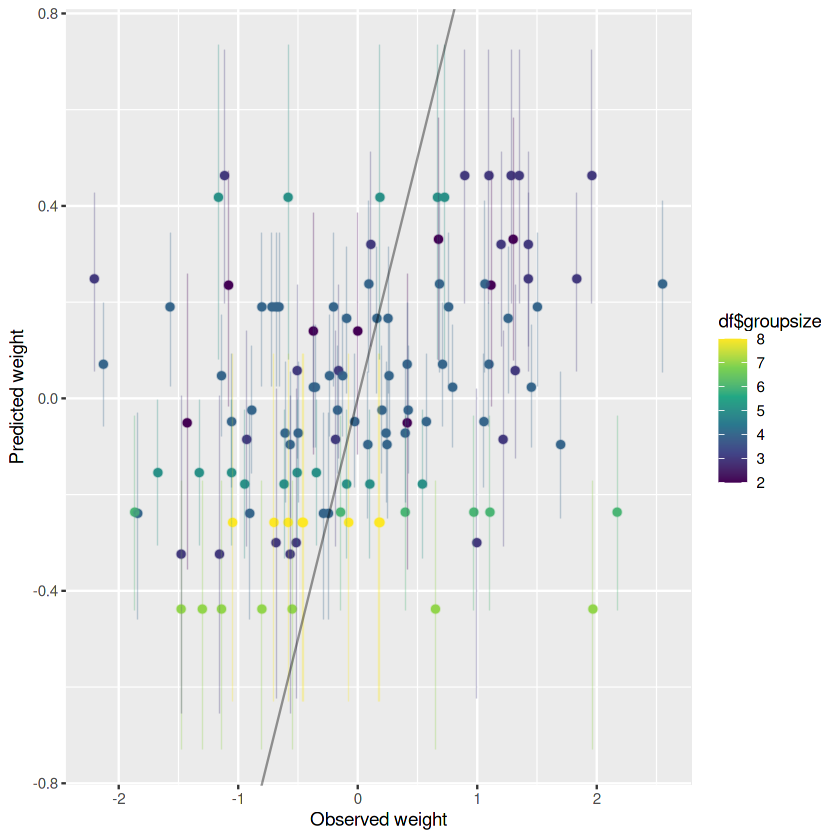

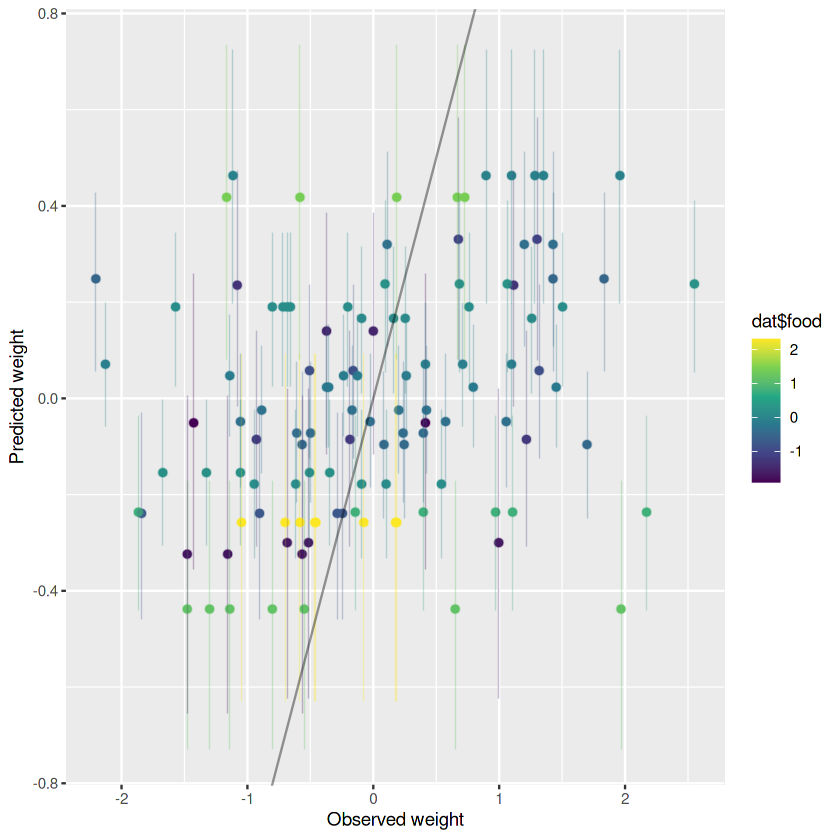

In [36]:
qplot(x=dat$weight, 
      y=mu_mean, 
      ymin= mu.min,
      ymax=mu.max,
      color=df$groupsize) +
    geom_pointrange(size=.3, alpha=0.3)+
    geom_abline(alpha=0.4) +
    xlab("Observed weight") +
    ylab("Predicted weight") +
    scale_color_viridis_c()

qplot(x=dat$weight, 
      y=mu_mean, 
      ymin= mu.min,
      ymax=mu.max,
      color=dat$food) +
    geom_pointrange(size=.3, alpha=0.3)+
    geom_abline(alpha=0.4) +
    xlab("Observed weight") +
    ylab("Predicted weight") +
    scale_color_viridis_c()

In [37]:
sim_dat <- data.frame(groupsize=(c(1,10) - mean(df$groupsize)) / sd(df$groupsize), food=0)

In [38]:
s <- sim(model.2b, data=sim_dat, vars=c('weight'))

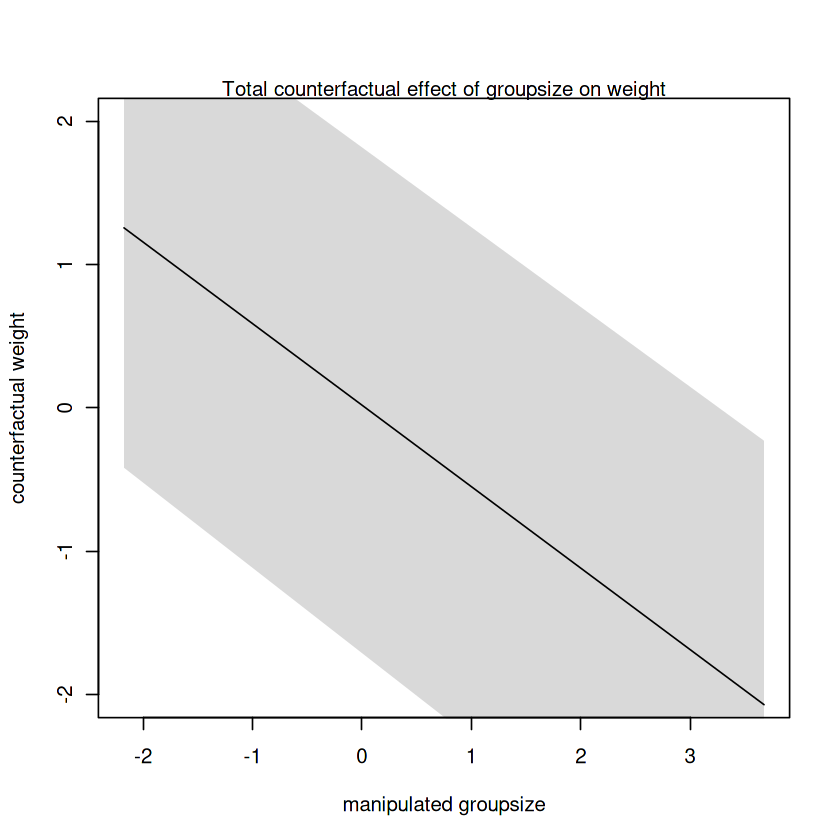

In [39]:
plot( sim_dat$groupsize , colMeans(s) , ylim=c(-2,2) , type="l" ,
xlab="manipulated groupsize" , ylab="counterfactual weight"
)
shade( apply(s,2,PI) , sim_dat$groupsize )
mtext( "Total counterfactual effect of groupsize on weight" )

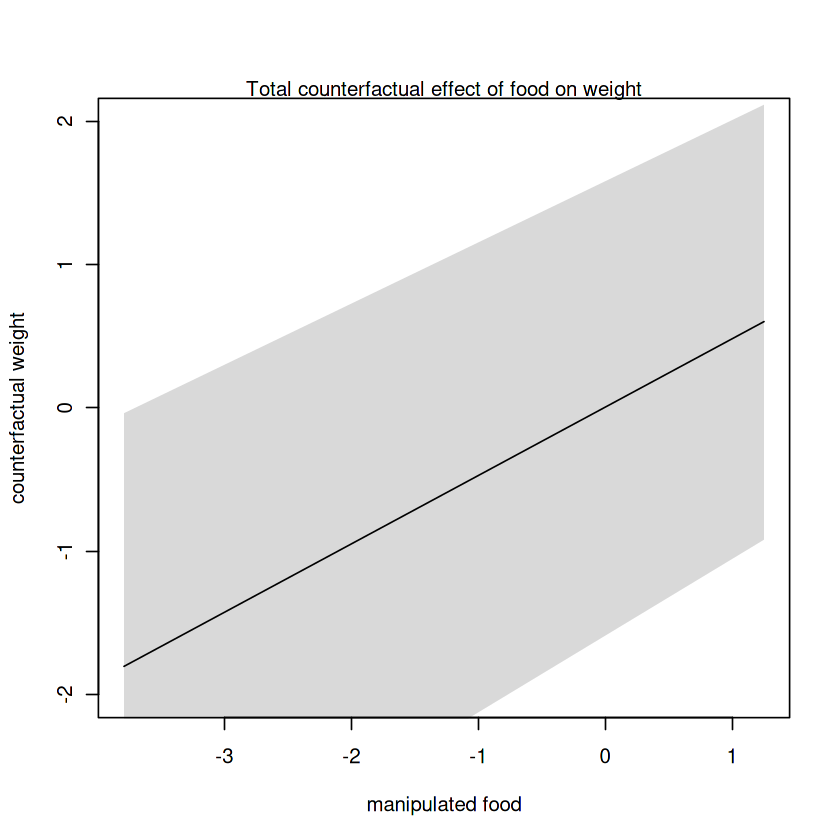

In [40]:
sim_dat <- data.frame(food=(c(0,1) - mean(df$avgfood)) / sd(df$avgfood), groupsize=0)
s <- sim(model.2b, data=sim_dat, vars=c('weight'))
plot( sim_dat$food , colMeans(s) , ylim=c(-2,2) , type="l" ,
xlab="manipulated food" , ylab="counterfactual weight"
)
shade( apply(s,2,PI) , sim_dat$food )
mtext( "Total counterfactual effect of food on weight" )

In [41]:
fseq <- seq(from = -3, to = 3, length.out = 1e2)
gseq <- seq(from = -3, to = 3, length.out = 1e2)

In [42]:
grid <- expand.grid(x=fseq, y = gseq)

In [43]:
grid <- grid %>% mutate(mu = mean(post.2b$alpha) + mean(post.2b$beta_f) * x  + mean(post.2b$beta_g) * y)

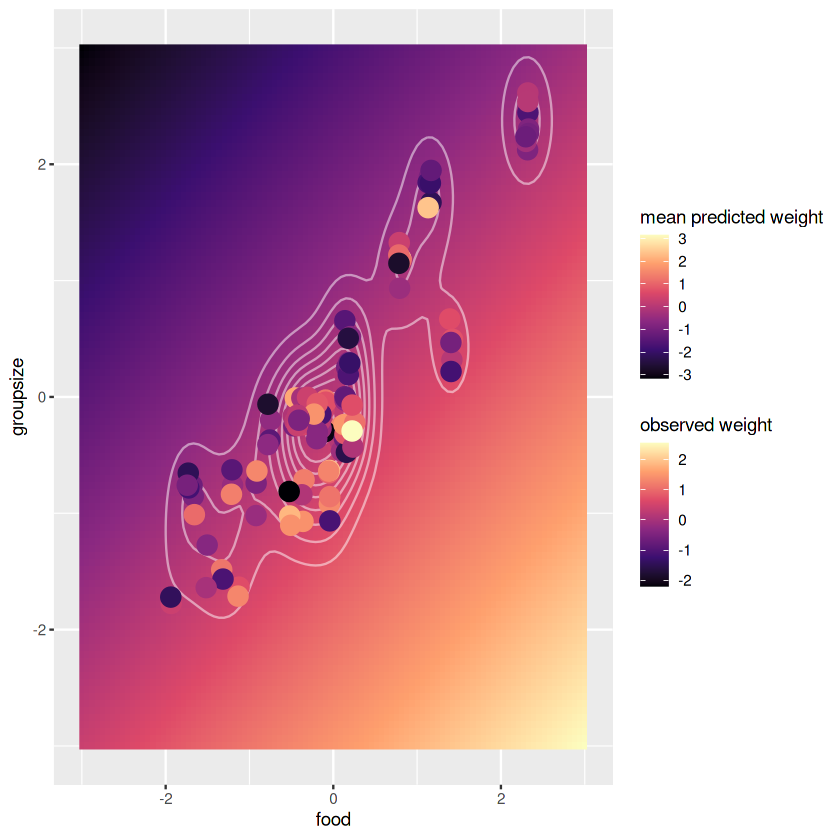

In [44]:
ggplot(NULL, 
       aes(x,y,fill)) +
    geom_raster(data=grid, 
                aes(x = x, y=y, fill=mu)) +
    geom_density_2d(data=df, 
                    aes(x=std.food,
                        y=std.groupsize),
                    color="white", alpha=0.5) +
    geom_jitter(data=df,
                aes(x=std.food,
                    y=std.groupsize,
                    color=std.weight), 
                size=5) +
    xlab("food") +
    ylab("groupsize") +
    labs(fill = 'mean predicted weight',
         color="observed weight") +

    scale_fill_viridis_c(option = 'magma') +
    scale_color_viridis_c(option = 'magma')

### Interpretation

There is a lot of influence of food passing through group size. The group size pushes the avarage weight of the foxes down with similar force to the one positively exerceted by the food availability. 

The total effect of food availability in weight is very small, around -0.17 and 0.12 standard deviations of weight per change of 1 standard deviation of food.
But the direct effect much more noticeable, as it falls around 0.19 and 0.76 standard deviations of weight per change of 1 standard deviation of food.

There seems to be nevertheless a balancing effect from the causal effect of group size and weight. Our last model shows the direct effect of group size on weight, and it has a negative causal effect around -0.86 and -0.29 standard deviations of weight per change of 1 standard deviation of group size.
This means that as the packs get bigger, their avarage weight decreases (as they must share the same food available).

The correlation between $\beta_{\text{food}}$ and $\beta_{group\ size}$ (-0.87) and their overal correlation favours the conclusion that the more food is available, the bigger the packs might get, but overall their weight will remain stable, as they will be sharing the food they might find.

## Exercice 3

### Question
Reconsider the Table 2 Fallacy example (from Lecture 6), this time with an
unobserved confound U that influences both smoking S and stroke Y. Here’s the modified DAG:

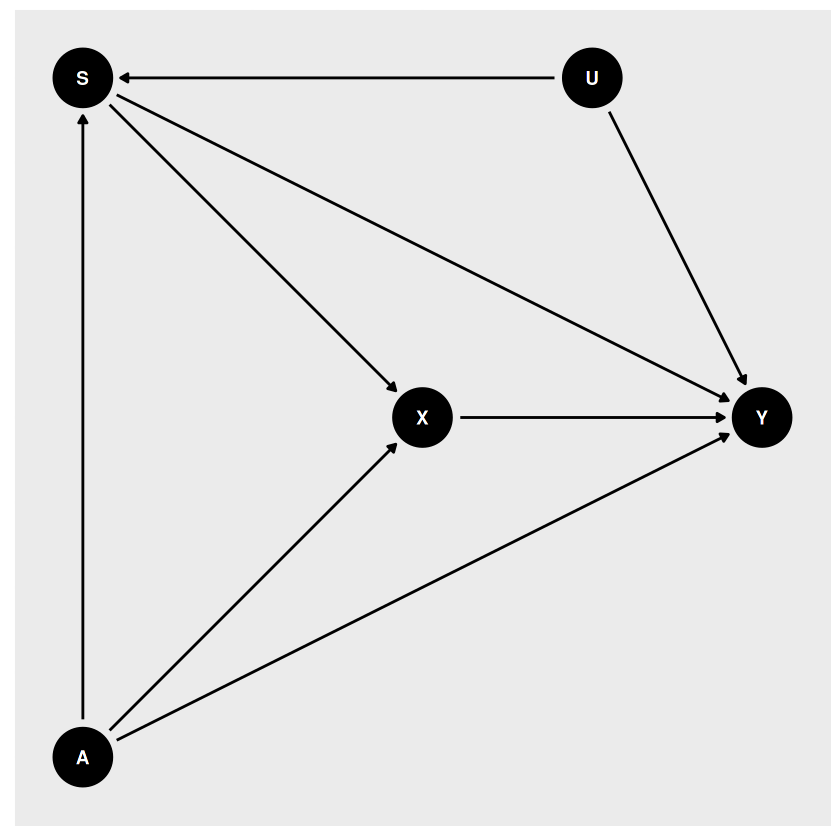

In [45]:
dag <- dagitty('dag{
S [pos="-1,1"]
A [pos="-1,-1"]
X [exposure, pos="0,0"]
U [latent, pos="0.5,1"]
Y [outcome, pos="1, 0"]
S -> X
A -> S
U -> S
S -> Y
X -> Y
A -> X
A -> Y
U -> Y
}')
ggdag(dag) + theme_dag_gray()

First use the backdoor criterion to determine an adjustment set that allows
you to estimate the causal effect of X on Y, i.e. $P(Y|do(X))$. Second explain
the proper interpretation of each coefficient implied by the regression model
that corresponds to the adjustment set. Which coefficients (slopes) are causal
and which are not? There is no need to fit any models. Just think through
the implications.


### Answer

$A$ is a fork of the causal relation $X \rightarrow Y$, so the data must be stratified by $A$.
The same is true to $S$.
The ajustment set must be $\{S, A\}$ (to which the `dagitty` package agrees).

In [46]:
dagitty::adjustmentSets(dag)

{ A, S }

Model:

$y_i \sim \text{Some Distribution}(\mu_i, \sigma)$

$\mu_i = \alpha + \beta_A * smokes_i + \beta_A * age_i + \beta_x * x_i$

By stratifying the data by $\{S, A\}$ we get the unbiased direct and total causal effect of $X$ on $Y$, $\beta_X$, nevertheless, the effects $\beta_S$ and $\beta_A$ will be biassed:

The effect of $A$ on $Y$, $\beta_A$, is not causal, as its effect will flow by the causal path between it and the unobserved variable $U$ opened by stratifying by $S$, a colider.

The effect of $S$ on $Y$, $\beta_S$ is not causal, as its effect will flow by the causal path between it and $A$ opened by stratifying by $X$, a colider, and part of it will flow by $X$ if only $A$ was to be stratified, as $X$ is a pipe. 